In [1]:
import os
import glob
import random
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def post_processing(img, k1=(55,55), k2=(25,25), region_size=3000):
    # Close small gap inside of the segmentation
    kernel = np.ones(k1, np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    # erosion and dialation of the images
    kernel = np.ones(k2, np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    
    # Again remove the small regions
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    max_size = region_size
    for i in range(0, nb_components):
        if sizes[i] <= max_size:
            img[output == i + 1] = 0
    
    # Smooth the edges
    kernel = np.ones((5,5),np.float32)/25
    img = cv2.filter2D(img,-1,kernel)
    
    # Close the small gaps 
    kernel = np.ones(k1, np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    return img

In [3]:
def dice_coefficient(seg, gt):
    dice = np.sum(seg[gt==255])*2.0 / (np.sum(seg) + np.sum(gt))
    return dice

In [4]:
def compute_iou(seg, gt):
    intersection = np.sum(seg[gt==255])
    union = np.sum(seg) + np.sum(gt) - intersection
    iou = intersection/union
    return iou                               

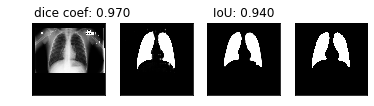

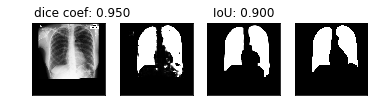

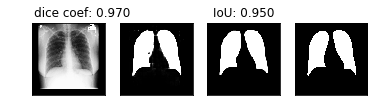

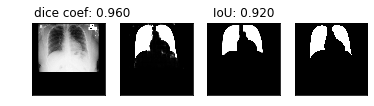

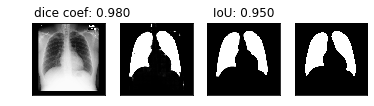

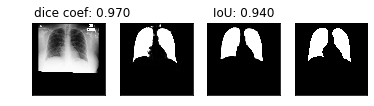

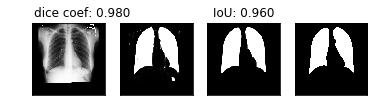

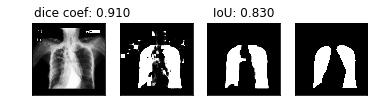

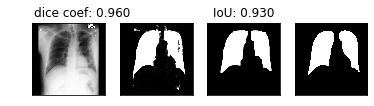

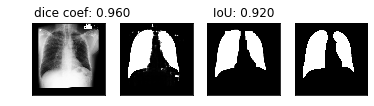

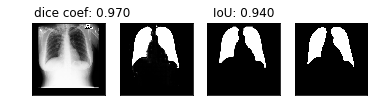

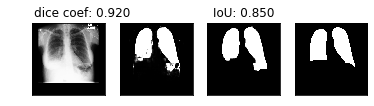

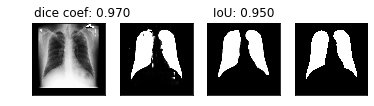

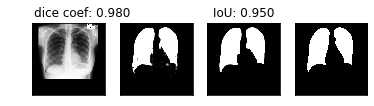

Average Dice Coefficient: 0.9600
Average Jaccard Index: 0.9238


In [10]:
img_dir = "data_64/val"
cxr_dir = os.path.join(img_dir, "cxr")
mask_dir = os.path.join(img_dir, "mask")
output_dir = os.path.join(img_dir, "outputs")
save_dir = os.path.join(img_dir, "post_processed_outputs")

#file = "MCUCXR_0024_0.png"
total_dc = 0
total_iou = 0
for file in os.listdir(output_dir):
    cxr = cv2.imread(os.path.join(cxr_dir, file), 0)
    mask = cv2.imread(os.path.join(mask_dir, file), 0)
    img = cv2.imread(os.path.join(output_dir, file), 0)

    # Image theresholding 
    img_thresh = np.copy(img)
    bg = np.where(img_thresh[:,:] < 100)
    fg = np.where(img_thresh[:,:] >= 100)
    img_thresh[bg] = 0
    img_thresh[fg] = 255
    
    # Take the two largest region
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_thresh, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    
    lung_1 = np.zeros(img.shape, np.uint8)
    lung_2 = np.zeros(img.shape, np.uint8)
    
    i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-1]))[0][0]
    lung_1[output == i+1] = 255

    i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-2]))[0][0]
    lung_2[output == i+1] = 255
    
    lung_1 = post_processing(lung_1, k1=(45,45), k2=(25,25))
    lung_2 = post_processing(lung_2, k1=(45,45), k2=(25,25))
    
    final_img = cv2.add(lung_1, lung_2)
    
    # Calculate dice coefficient
    dice = dice_coefficient(final_img, mask)
    total_dc += dice
    #print('Dice similarity score is {}'.format(dice))
    
    # Calculate Intersection-Over-Union (Jaccard Index)
    iou = compute_iou(final_img, mask)
    total_iou += iou
    
    f, axarr = plt.subplots(1, 4)
    axarr[0].imshow(cxr, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    axarr[0].set_title(str("       dice coef: %.3f" %round(dice, 2)))
    
    axarr[1].imshow(img, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(final_img, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([])
    axarr[2].title.set_text(str("IoU: %.3f" %round(iou, 2))) 
    
    axarr[3].imshow(mask, cmap='gray')
    axarr[3].set_xticks([]), axarr[3].set_yticks([])
plt.show()

avg_dc = total_dc/len(os.listdir(output_dir))
avg_iou = total_iou/len(os.listdir(output_dir))

print("Average Dice Coefficient: %0.4f" %avg_dc)
print("Average Jaccard Index: %0.4f" %avg_iou)

In [9]:
print("Average Dice Coefficient: %.4f" %avg_dc)
print("Average Jaccard Index: %.4f" %avg_iou)

Average Dice Coefficient: 0.9716
Average Jaccard Index: 0.9449


#### Test chest x-ray images from other datasets (have no ground truth)

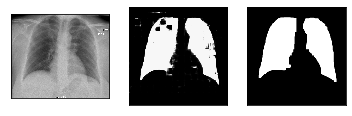

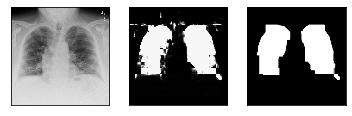

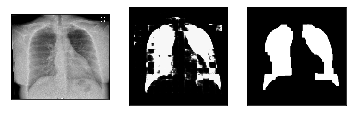

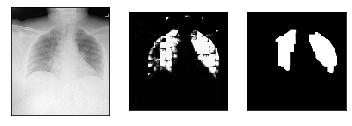

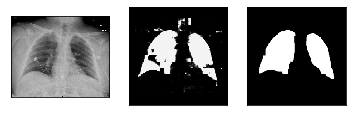

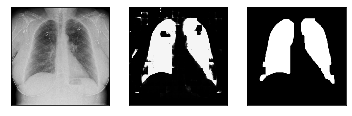

In [83]:
output_dir = "others/outputs"
cxr_dir = "others/cxr"

for file in os.listdir(output_dir):
    cxr = cv2.imread(os.path.join(cxr_dir, file), 0)
    img = cv2.imread(os.path.join(output_dir, file), 0)

    # Image theresholding 
    img_thresh = np.copy(img)
    bg = np.where(img_thresh[:,:] < 100)
    fg = np.where(img_thresh[:,:] >= 100)
    img_thresh[bg] = 0
    img_thresh[fg] = 255
    
    # Take the two largest region
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_thresh, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    
    lung_1 = np.zeros(img.shape, np.uint8)
    lung_2 = np.zeros(img.shape, np.uint8)
    
    i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-1]))[0][0]
    lung_1[output == i+1] = 255

    i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-2]))[0][0]
    lung_2[output == i+1] = 255
    
    # Post-processing two lung region seperately
    lung_1 = post_processing(lung_1, k1=(65,65), k2=(25,25))
    lung_2 = post_processing(lung_2, k1=(65,65), k2=(25,25))
    
    final_img = cv2.add(lung_1, lung_2)
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(cxr, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    
    axarr[1].imshow(img, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(final_img, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([]) 

plt.show()

#### Test any specific image

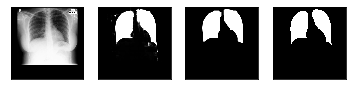

In [130]:
img_dir = "data_64/test"
cxr_dir = os.path.join(img_dir, "cxr")
mask_dir = os.path.join(img_dir, "mask")
output_dir = os.path.join(img_dir, "outputs")
save_dir = os.path.join(img_dir, "post_processed_outputs")

file = "MCUCXR_0024_0.png"

cxr = cv2.imread(os.path.join(cxr_dir, file), 0)
mask = cv2.imread(os.path.join(mask_dir, file), 0)
img = cv2.imread(os.path.join(output_dir, file), 0)

# Image theresholding 
img_thresh = np.copy(img)
bg = np.where(img_thresh[:,:] < 100)
fg = np.where(img_thresh[:,:] >= 100)
img_thresh[bg] = 0
img_thresh[fg] = 255

# Take the two largest region
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_thresh, connectivity=8)
sizes = stats[1:, -1]
nb_components = nb_components - 1

lung_1 = np.zeros(img.shape, np.uint8)
lung_2 = np.zeros(img.shape, np.uint8)

i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-1]))[0][0]
lung_1[output == i+1] = 255

i = (np.where(stats[1:, -1] == np.sort(stats[1:, -1])[-2]))[0][0]
lung_2[output == i+1] = 255

lung_1 = post_processing(lung_1, k1=(45,45), k2=(25,25))
lung_2 = post_processing(lung_2, k1=(45,45), k2=(25,25))

final_img = cv2.add(lung_1, lung_2)

f, axarr = plt.subplots(1, 4)
axarr[0].imshow(cxr, cmap='gray')
axarr[0].set_xticks([]), axarr[0].set_yticks([]) 

axarr[1].imshow(img, cmap='gray')
axarr[1].set_xticks([]), axarr[1].set_yticks([]) 

axarr[2].imshow(final_img, cmap='gray')
axarr[2].set_xticks([]), axarr[2].set_yticks([]) 

axarr[3].imshow(mask, cmap='gray')
axarr[3].set_xticks([]), axarr[3].set_yticks([]) 
plt.show()